In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
#Preliminary data analysis
#read the patient activities data
df_p_act=pd.read_csv('../source/PatientActivities.csv')
df_p_act.head()

,Id,HospitalNumber,EventOccured,EventRecorded,CreatedAt,Reversed,From_BedNumber,From_WardId,From_WardName,BedNumber,WardId,WardName,EpisodeReference,DToCDate,ExpectedDischargeDate,EventType,Status,TransferType
0,486849,1,27/7/2018 23:06,27/7/2018 23:07,27/7/2018 23:08,0,NaN,NaN,NaN,27,I_RXT65_RES,Reservoir Court,107168,NaN,NaN,Admission,3,0
1,487044,1,31/7/2018 13:14,31/7/2018 13:14,1/8/2018 9:08,0,NaN,NaN,NaN,27,I_RXT65_RES,Reservoir Court,107168,NaN,NaN,Update,3,0
2,487309,1,4/8/2018 13:34,4/8/2018 13:34,4/8/2018 13:34,0,27.0,I_RXT65_RES,Reservoir Court,22,I_RXT65_RES,Reservoir Court,107168,NaN,NaN,Transfer,3,2
3,488101,1,17/8/2018 15:07,17/8/2018 15:08,17/8/2018 15:08,0,NaN,NaN,NaN,22,I_RXT65_RES,Reservoir Court,107168,NaN,24/8/2018 0:00,Update,3,64
4,489074,1,5/9/2018 11:12,5/9/2018 11:16,5/9/2018 11:16,0,NaN,NaN,NaN,22,I_RXT65_RES,Reservoir Court,107168,NaN,28/9/2018 0:00,Update,3,64


In [3]:
df_p_act.shape

(31523, 18)

In [4]:
df_p_act.drop_duplicates(inplace=True)

In [5]:
df_p_act.columns = [col.replace(' ', '_') for col in df_p_act.columns]

In [6]:
# Drop rows which contain null values across all columns
df_p_act.dropna(how='all',inplace=True)

In [7]:
#check the dimension (no. of records and attributes) of the panda dataframe
df_p_act.shape

(30034, 18)

In [8]:
# remove entries related to 'transfer' within the same ward
df_p_act.drop(df_p_act[df_p_act.From_WardId==df_p_act.WardId].index,axis=0,inplace=True)

In [9]:
df_p_act['EventOccured']=pd.to_datetime(df_p_act['EventOccured'],format='%d/%m/%Y %H:%M')

In [10]:
df_p_act.reset_index(inplace=True)

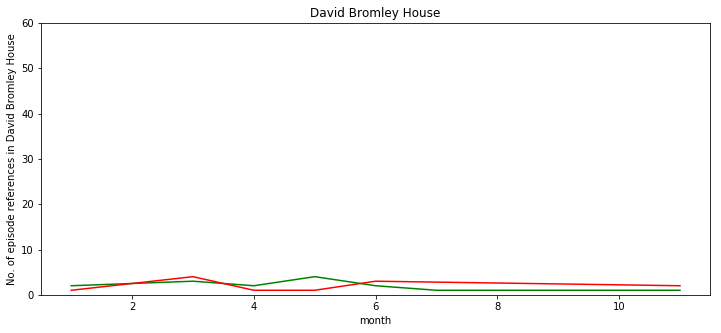

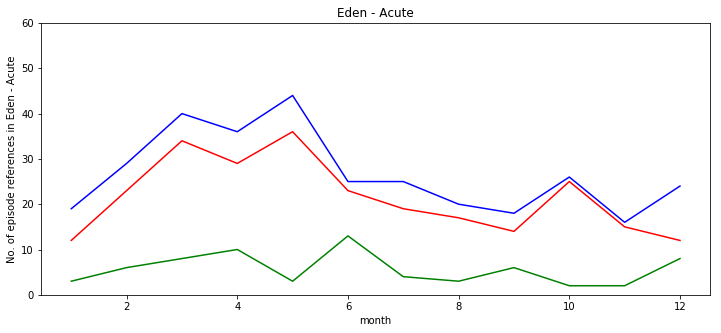

Tamarind - Lobelia value not found


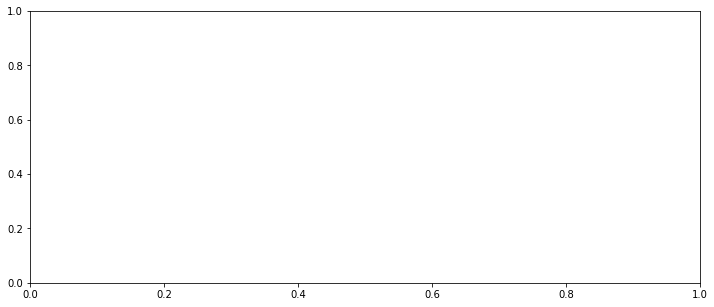

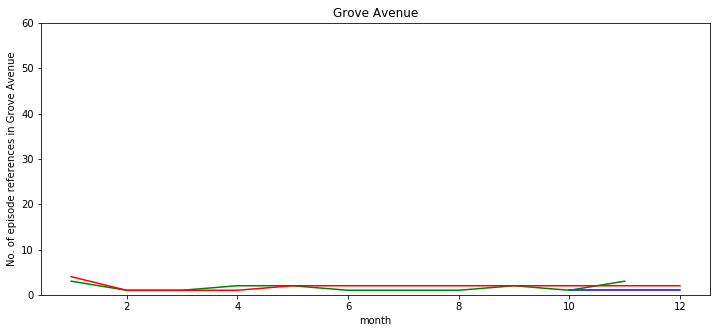

Reaside - Blythe value not found
Reaside - Severn value not found


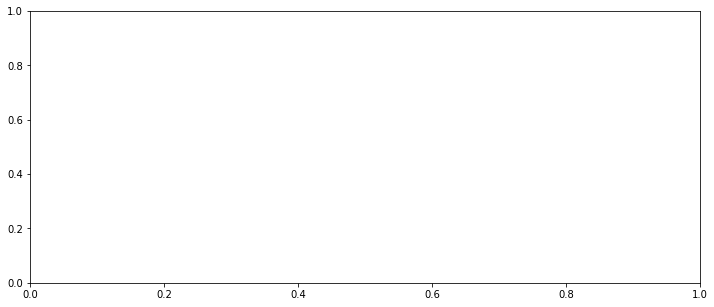

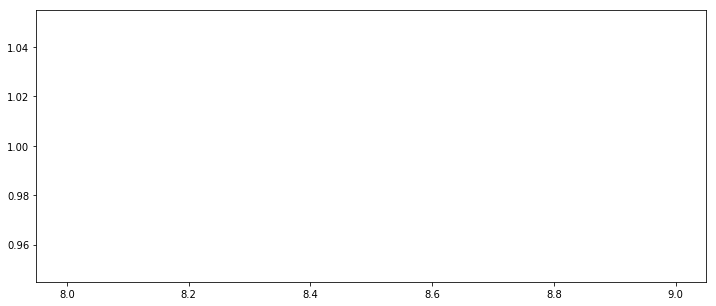

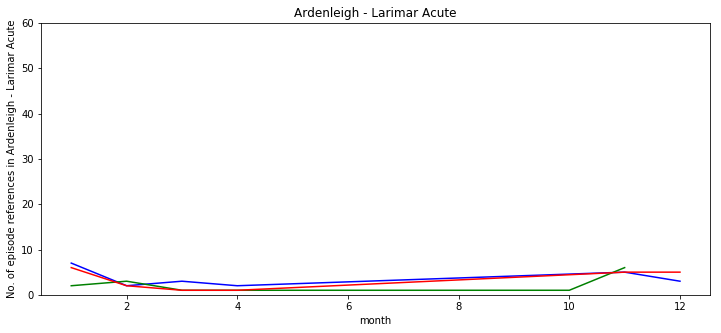

Tamarind - Acacia value not found
Ashcroft Inpatient Complex Care value not found
Reaside - Swift value not found


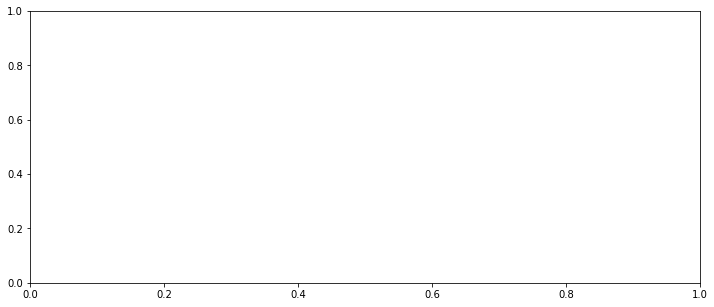

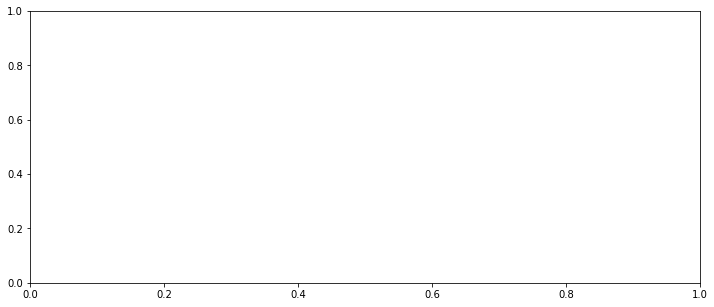

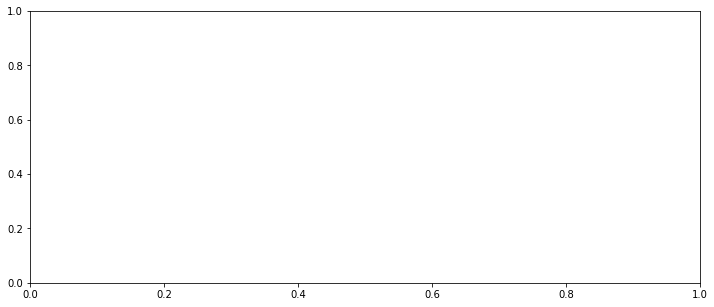

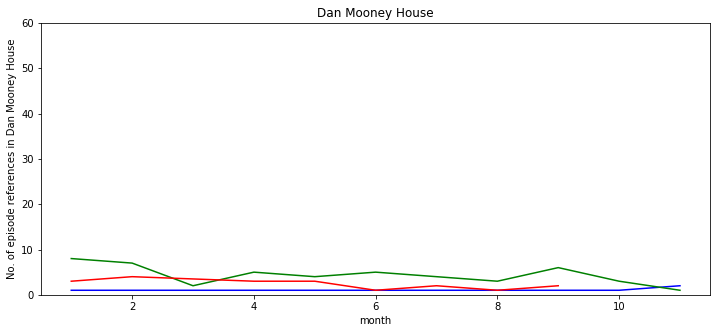

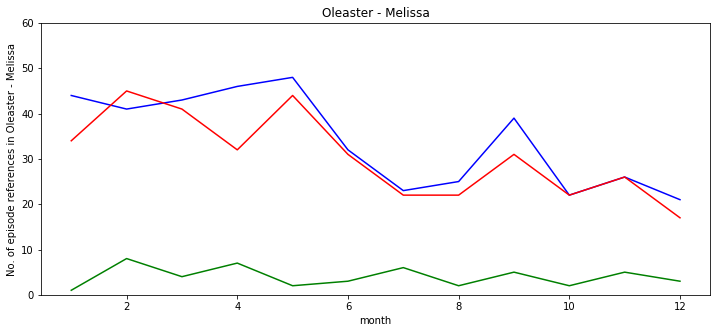

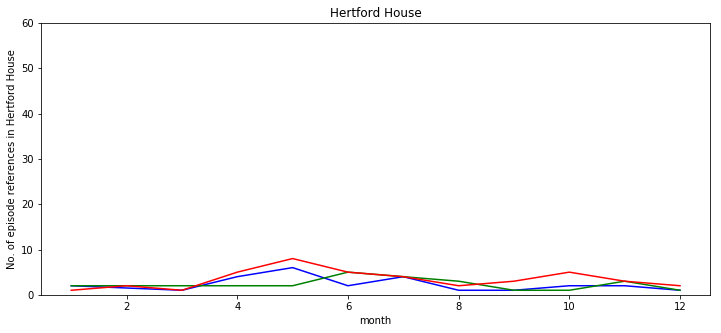

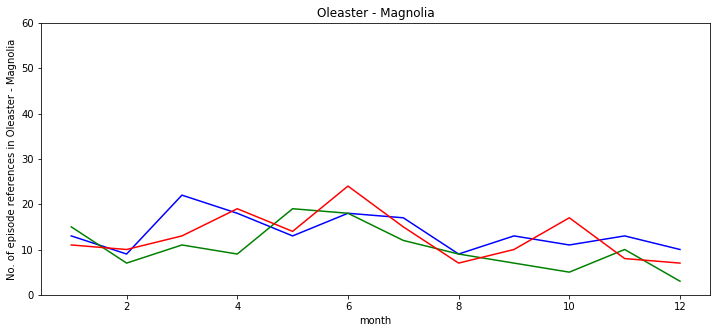

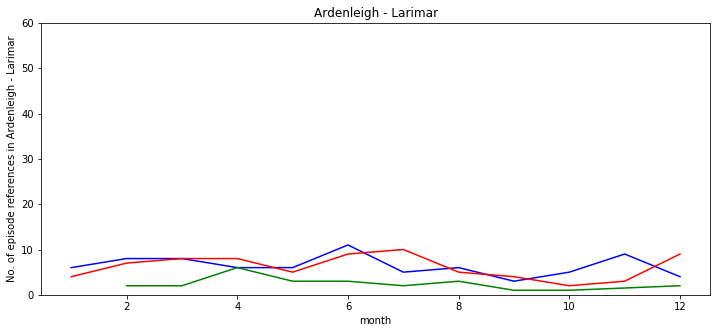

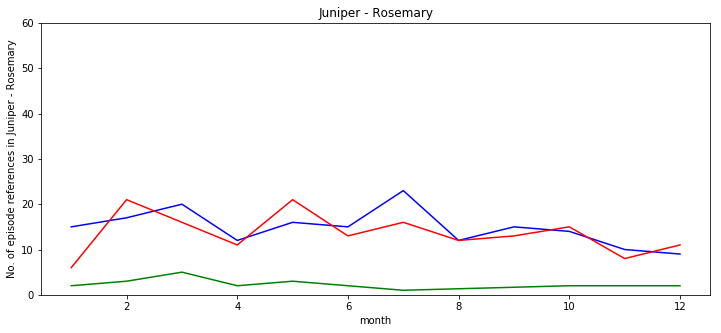

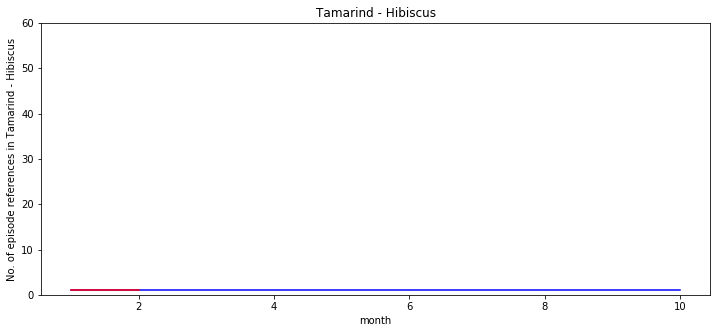

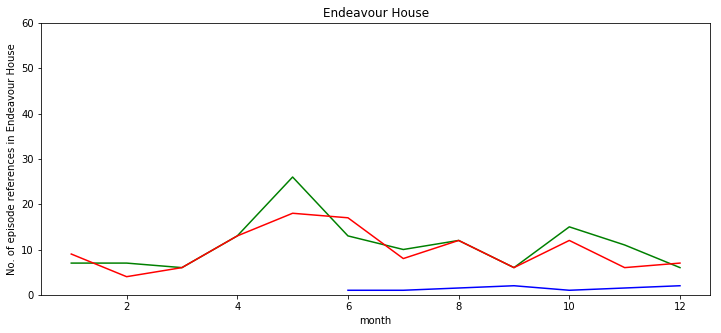

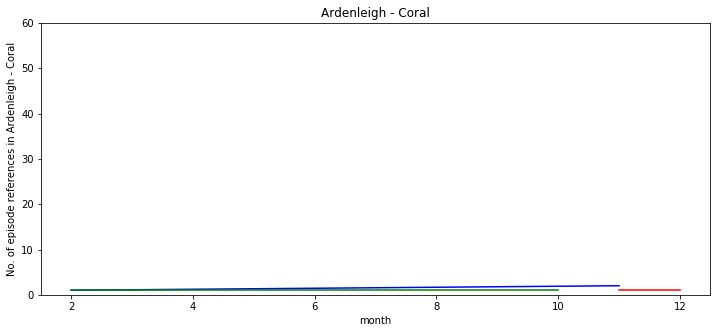

Ardenleigh - Citrine value not found


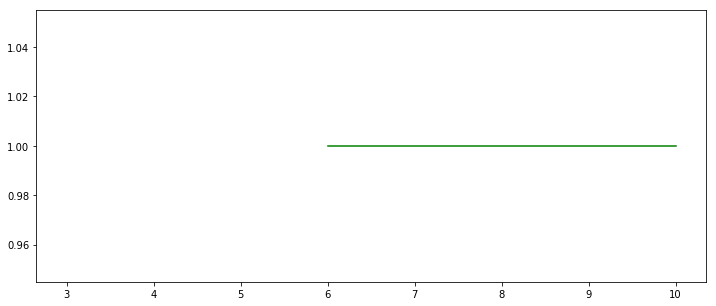

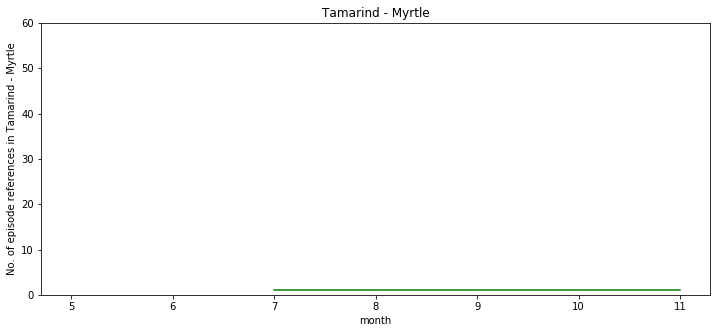

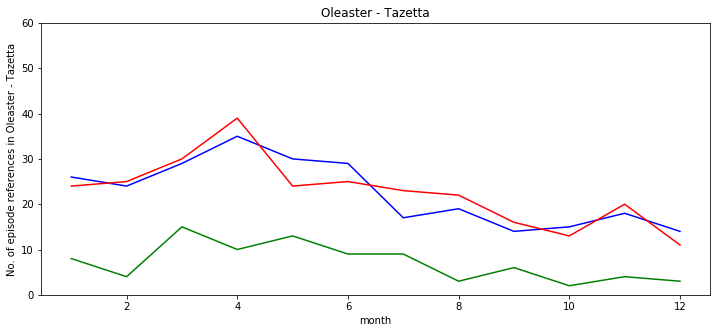

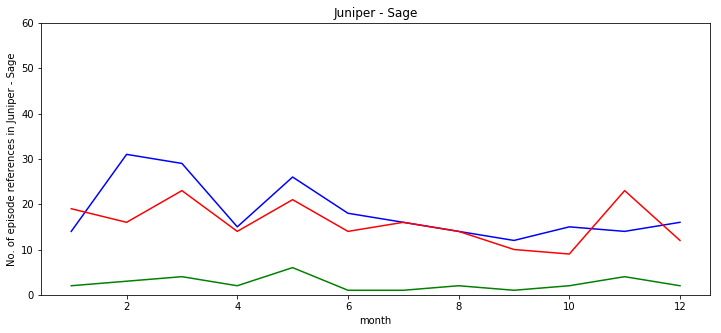

Tamarind - Cedar value not found


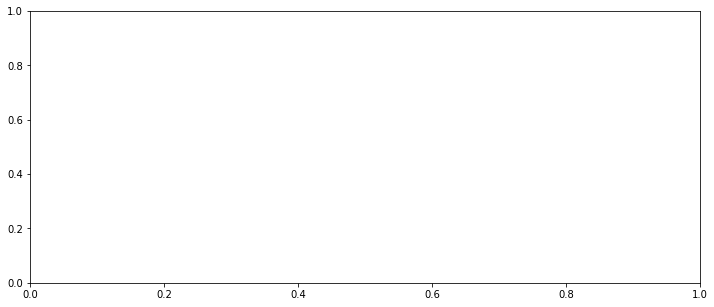

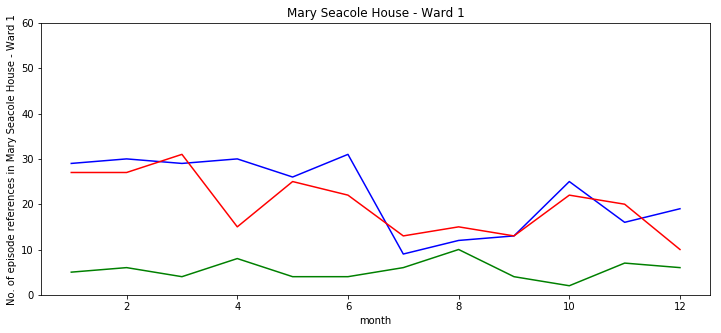

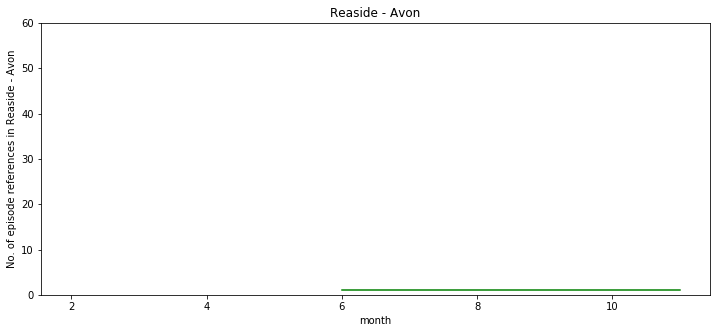

Barberry - Vitivier value not found


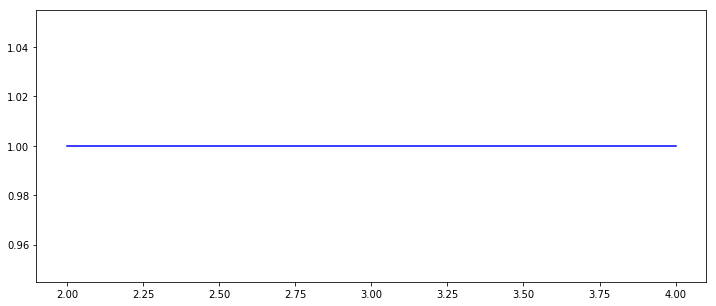

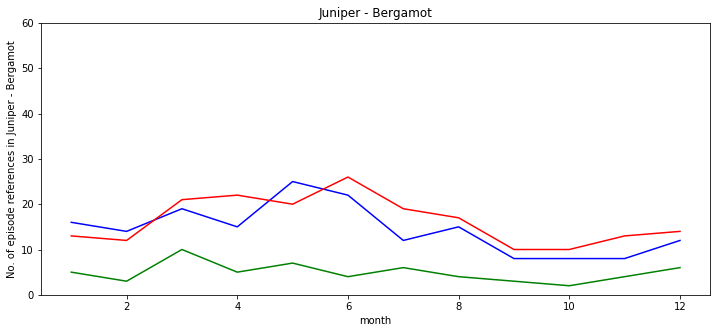

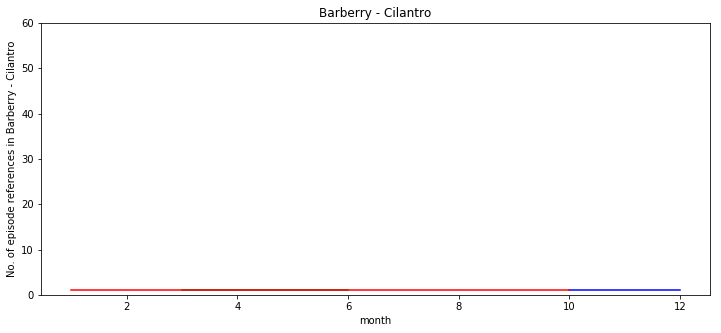

Chamomile Suite Infants value not found


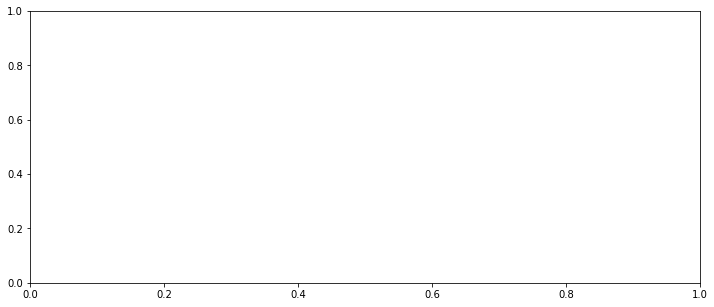

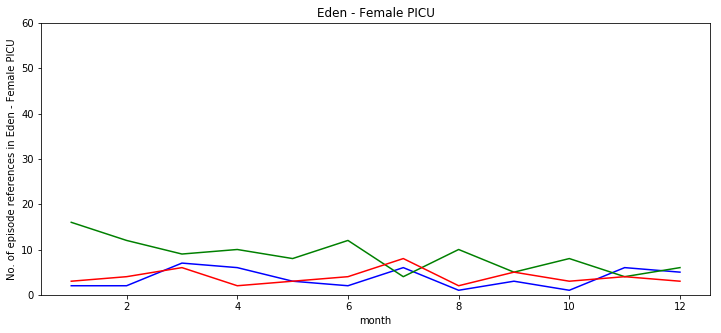

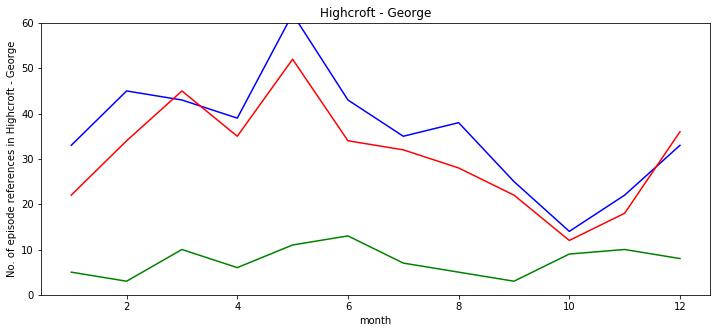

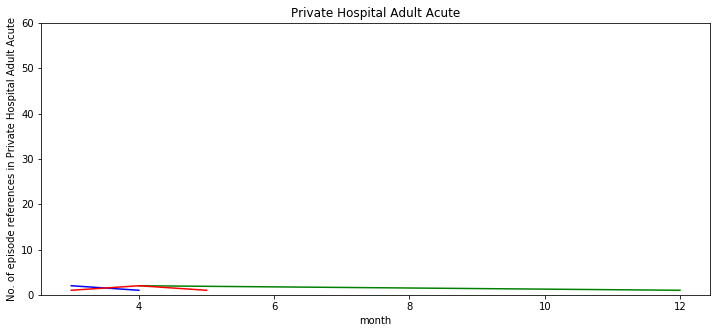

Reaside - Kennet value not found


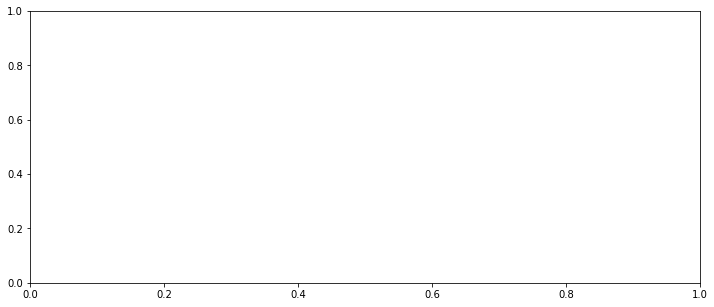

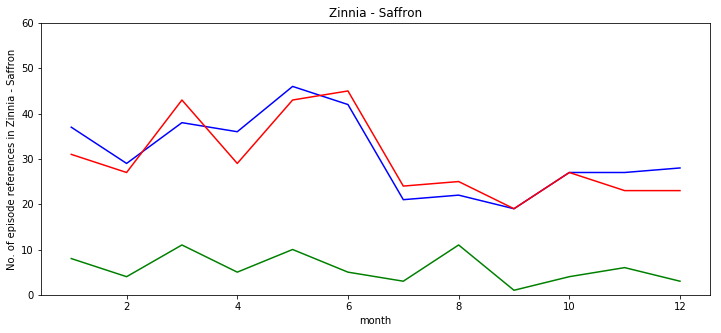

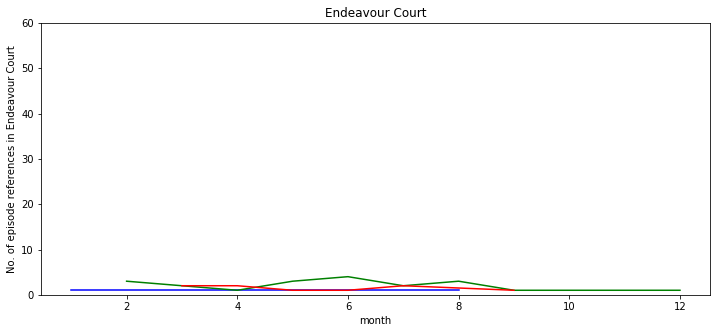

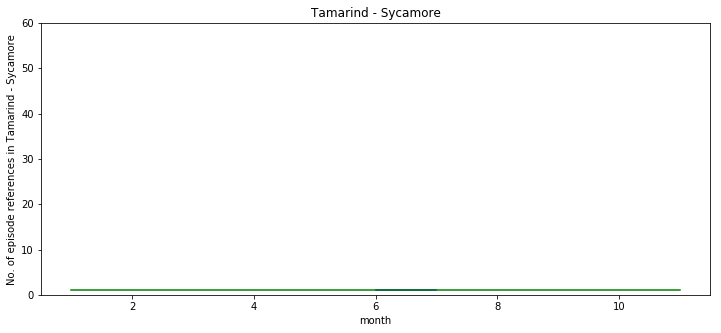

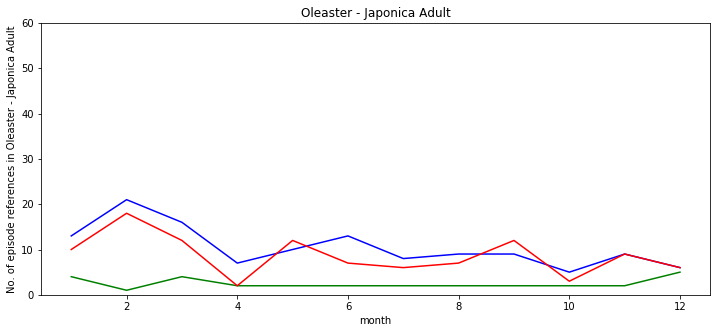

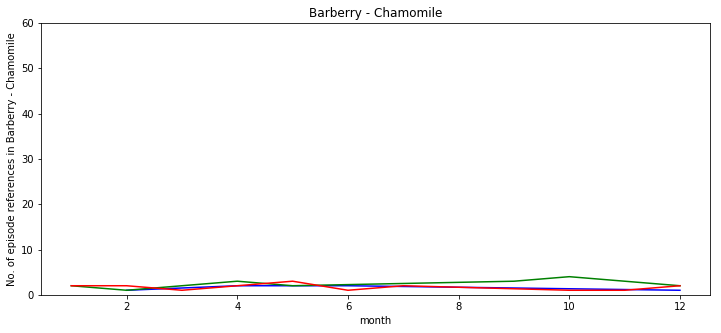

Ross House value not found


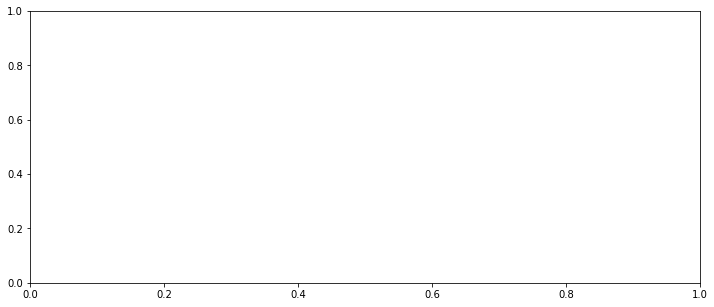

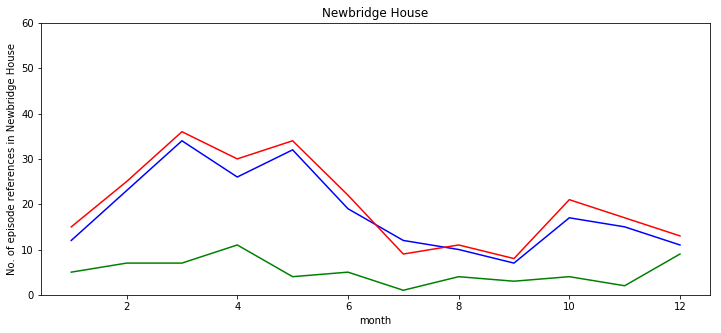

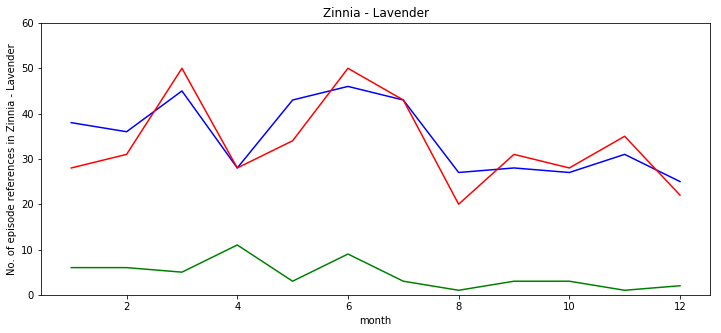

Endeavour House Acute value not found


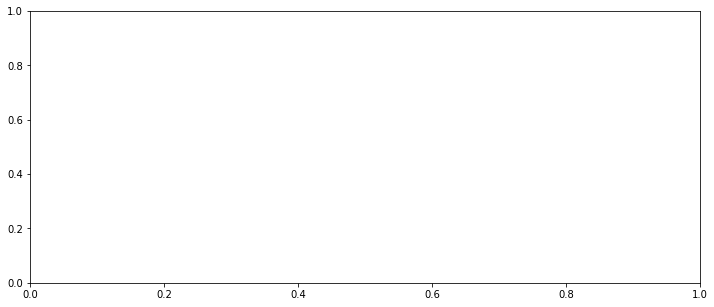

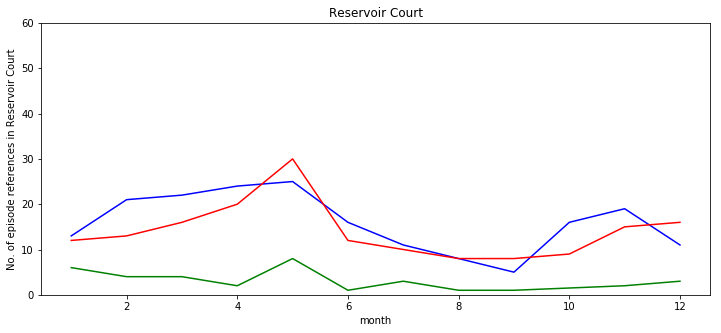

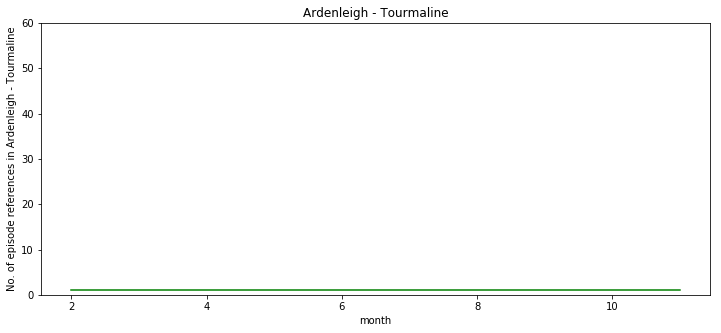

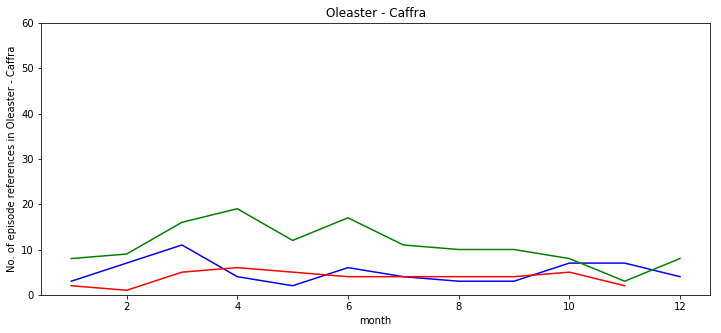

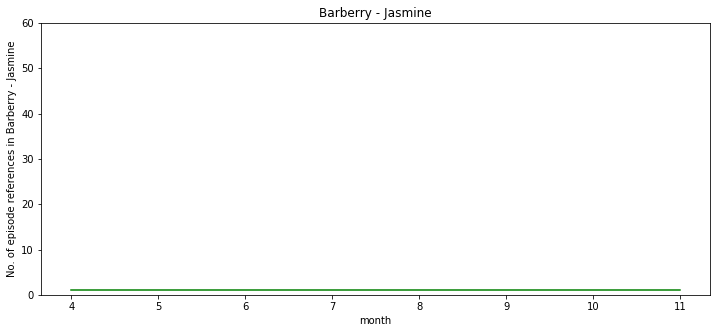

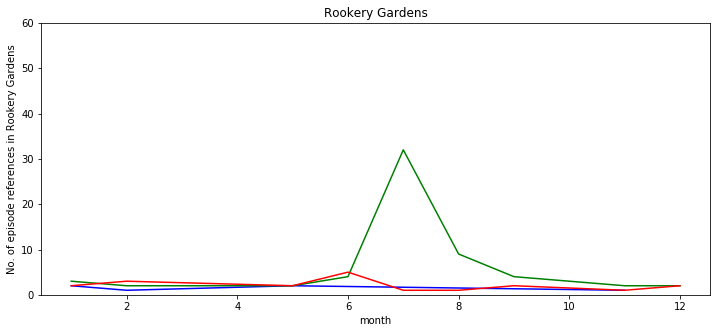

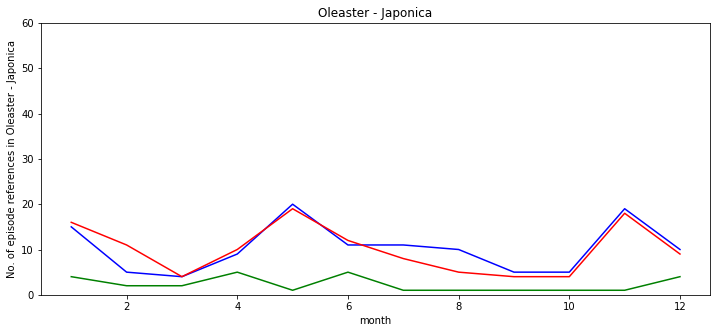

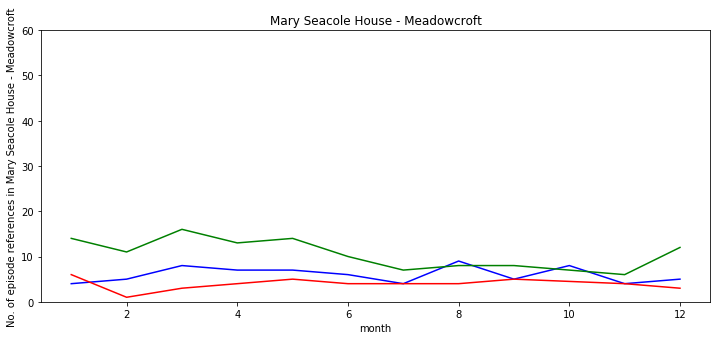

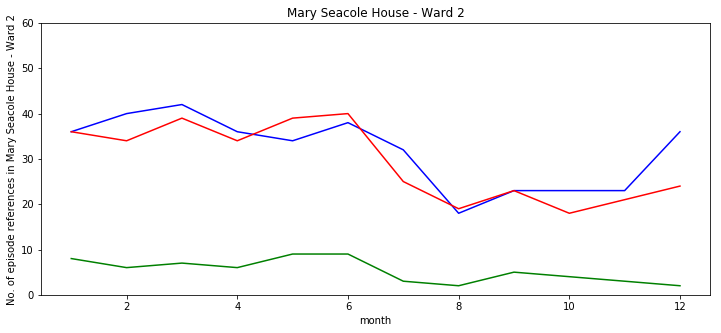

Ashcroft - Complex Care value not found


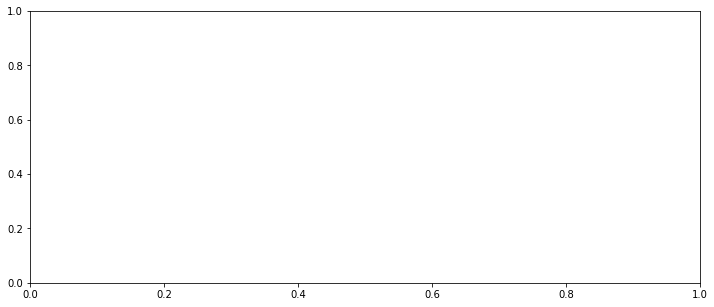

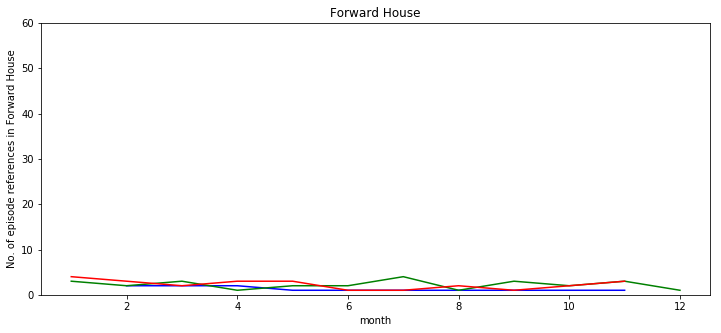

In [11]:
#check if there is any trend of admission or discharge across months

#per ward
for i in set(df_p_act.WardName):
    try:
        fig=plt.figure(figsize=(12,5))
        ax1=df_p_act[(df_p_act.EventType=='Admission') & (df_p_act.WardName==i)].EventOccured.dt.month.value_counts().sort_index().plot(color='blue')
        ax2=df_p_act[(df_p_act.EventType=='Transfer')& (df_p_act.WardName==i)].EventOccured.dt.month.value_counts().sort_index().plot(color='green')
        ax3=df_p_act[(df_p_act.EventType=='Discharge')& (df_p_act.WardName==i)].EventOccured.dt.month.value_counts().sort_index().plot(color='red')
        plt.title(i)
        plt.xlabel('month')
        plt.ylabel(f'No. of episode references in {i}')
        plt.ylim([0,60])

        plt.show()
    
    except TypeError:
        print(f'{i} value not found')


In [12]:
d=df_p_act[(df_p_act.EventType=='Admission')].EventOccured.dt.month.value_counts().sort_index()

In [13]:
d.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

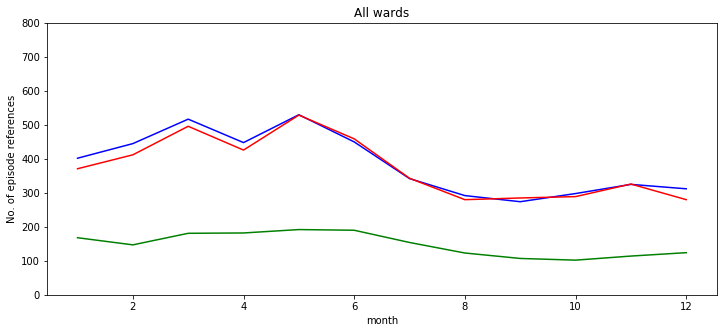

In [14]:
plt.figure(figsize=(12,5))
ax1=df_p_act[(df_p_act.EventType=='Admission')].EventOccured.dt.month.value_counts().sort_index().plot(color='blue')
ax2=df_p_act[(df_p_act.EventType=='Transfer')].EventOccured.dt.month.value_counts().sort_index().plot(color='green')
ax3=df_p_act[(df_p_act.EventType=='Discharge')].EventOccured.dt.month.value_counts().sort_index().plot(color='red')
plt.title('All wards')
plt.xlabel('month')
plt.ylabel(f'No. of episode references')
plt.ylim([0,800])

plt.show()

In [15]:
#Prepare the label column (y) i.e. length of stays 
admission_date=df_p_act[df_p_act.EventType=='Admission'][['HospitalNumber','EpisodeReference','WardId','EventOccured']]
admission_date.rename(columns={'EventOccured':'Admission_Date','WardId':'Admission_WardId'},inplace=True)
transfer_date=df_p_act[df_p_act.EventType=='Transfer'][['EpisodeReference','EventOccured','WardId','From_WardId','TransferType']]
transfer_date.rename(columns={'EventOccured':'Transfer_Date','WardId':'To_Ward'},inplace=True)
discharge_date=df_p_act[df_p_act.EventType=='Discharge'][['EpisodeReference','EventOccured']]
discharge_date.rename(columns={'EventOccured':'Discharge_Date'},inplace=True)

In [16]:
for i in [admission_date,transfer_date,discharge_date]:
    i.drop_duplicates(inplace=True)

In [17]:
discharge_date.sort_values(by='Discharge_Date',ascending=False,inplace=True)

In [18]:
# Keep the most recent discharge date for each episode reference
discharge_date=discharge_date.groupby('EpisodeReference').first()

In [19]:
admission_date.sort_values(by='Admission_Date',ascending=True,inplace=True)

In [20]:
# Keep the earliest admission date for each episode reference
admission_date=admission_date.groupby('EpisodeReference').first()

In [21]:
df_los=pd.merge(admission_date,transfer_date,on='EpisodeReference',how='outer')

In [22]:
df_los_t=pd.merge(df_los,discharge_date,on='EpisodeReference',how='outer')

In [23]:
df_los_t['Start_Date']=''
df_los_t['End_Date']=''
df_los_t['Ward']=''

In [24]:
df_los_a=df_los_t[np.isnat(df_los_t.Transfer_Date)]

In [25]:
df_los_a.Start_Date=df_los_a.Admission_Date
df_los_a.End_Date=df_los_a.Discharge_Date
df_los_a.Ward=df_los_a.Admission_WardId

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [26]:
df_los_a=df_los_a[~(df_los_a.End_Date.isnull() | df_los_a.Start_Date.isnull())]

In [27]:
df_los_b=df_los_t[~(np.isnat(df_los_t.Transfer_Date))]

In [28]:
df_los_b1=df_los_b.copy()

In [29]:
df_los_b2=pd.concat([df_los_b,df_los_b1],axis=0)

In [30]:
df_los_b2.sort_values(by=['EpisodeReference','Transfer_Date'],inplace=True)

In [31]:
df_los_b2.reset_index(inplace=True)

In [32]:
df_los_b2.drop(['index'],axis=1,inplace=True)

In [33]:
from numpy import nan
for i in df_los_b2.EpisodeReference.unique():
    idx=df_los_b2[df_los_b2.EpisodeReference==i].index
    for j in range(len(idx)):
        if j==0:
            df_los_b2.loc[idx[j],'Start_Date']=df_los_b2.loc[idx[j],'Admission_Date']
            df_los_b2.loc[idx[j],'End_Date']=df_los_b2.loc[idx[j],'Transfer_Date']
            df_los_b2.loc[idx[j],'Ward']=df_los_b2.loc[idx[j],'Admission_WardId']
        elif (j+1)==len(idx):
            df_los_b2.loc[idx[j],'Start_Date']=df_los_b2.loc[idx[j],'Transfer_Date']
            df_los_b2.loc[idx[j],'End_Date']=df_los_b2.loc[idx[j],'Discharge_Date']
            df_los_b2.loc[idx[j],'Ward']=df_los_b2.loc[idx[j],'To_Ward']
        else:
            df_los_b2.loc[idx[j],'Start_Date']=df_los_b2.loc[idx[j],'Transfer_Date']
            df_los_b2.loc[idx[j],'Ward']=df_los_b2.loc[idx[j],'To_Ward']
            #end date
            boolean=(df_los_b2.loc[idx[j],'Transfer_Date']<=df_los_b2.loc[idx[j+1],'Transfer_Date'])
            if ((df_los_b2.loc[idx[j],'To_Ward']==df_los_b2.loc[idx[j+1],'From_WardId']) & boolean):
                df_los_b2.loc[idx[j],'End_Date']=df_los_b2.loc[idx[j+1],'Transfer_Date']
            else:
                df_los_b2.loc[idx[j],'End_Date']=nan
    

In [34]:
df_los_b=df_los_b2[~(df_los_b2.End_Date.isnull() | df_los_b2.Start_Date.isnull())]

In [35]:
df_los_b.drop_duplicates(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
df_p_act=pd.concat([df_los_a,df_los_b],axis=0)

In [37]:
df_p_act.drop(['Admission_WardId','Admission_Date','Transfer_Date','To_Ward','Discharge_Date'],axis=1,inplace=True)

In [38]:
#Calculate the length of stays
df_p_act['los_days']=(df_p_act['End_Date']-df_p_act['Start_Date']).dt.days

In [39]:
df_p_act['los_days'].describe()

count    5860.000000
mean       43.320648
std        61.773494
min      -238.000000
25%         9.000000
50%        23.000000
75%        53.000000
max       720.000000
Name: los_days, dtype: float64

In [40]:
df_p_act['start_month']=df_p_act['Start_Date'].dt.month

In [41]:
df_p_act.isnull().sum()

EpisodeReference       0
HospitalNumber       138
From_WardId         3385
TransferType        3385
Start_Date             0
End_Date               0
Ward                   0
los_days               0
start_month            0
dtype: int64

In [42]:
df_p_act=df_p_act[~(df_p_act.HospitalNumber.isnull())]

In [43]:
df_p_act.fillna(0,inplace=True)

In [44]:
#read ward information
df_w=pd.read_csv('../source/ward_type.csv')

In [45]:
df_w.head()

,Unnamed: 0,Inpatient ward types,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Ward Code,Ward Name,Ward Location,Ward Service Type,Intended Age Group,In Use,Ward Sex
1,NaN,I_RXT05_ADRIATLS,Ardenleigh - Adriatic,Ardenleigh,CAMHS Low Secure,Adolescent,Yes,Female
2,NaN,I_RXT05_ADRIAT,Ardenleigh - Adriatic - FCAMHS,Ardenleigh,Forensic CAMHS,Child/Adolescent,No,Any
3,NaN,I_RXT_ARARM,Ardenleigh - Armstrong,Ardenleigh,Forensic CAMHS,Child/Adolescent,No,Any
4,NaN,I_RXT05_ATLANT,Ardenleigh - Atlantic,Ardenleigh,Forensic CAMHS,Adolescent,Yes,Any


In [46]:
df_w.drop(['Unnamed: 0'],axis=1,inplace=True)

In [47]:
df_w.columns=df_w.iloc[0]

In [48]:
df_w.drop([0],inplace=True)

In [49]:
df_w.sample(5)

,Ward Code,Ward Name,Ward Location,Ward Service Type,Intended Age Group,In Use,Ward Sex
19,I_RXT_CHAM,Chamberlain QEPH (not in use),Queen Eliz. Psych H.,Adult Acute,Adult,No,Any
73,I_RXT_SOL10A,Solihull Hospital Ward 10A,Solihull Hospital,Older Adult Acute,Older Adult,No,Any
55,I_RXT64_RSAV,Reaside - Avon,Reaside Clinic,Medium Secure,Adult,Yes,Male
49,I_RXT_ASHCC,OP CC Ashcroft,Ashcroft Unit,Continuing Care - Older Adult,Older Adult,No,Any
29,I_RXT24_GROVE,Grove Avenue,Grove Avenue,Rehabilitation,Adult,Yes,Any


In [50]:
df_w.columns

Index(['Ward Code', 'Ward Name', 'Ward Location', 'Ward Service Type',
       'Intended Age Group', 'In Use', 'Ward Sex'],
      dtype='object', name=0)

In [51]:
df_w=df_w[['Ward Code','Ward Name','Ward Service Type','Ward Location']]

In [52]:
df_w['Ward Code']=df_w['Ward Code'].apply(lambda x: x.strip())

In [53]:
df_p_act_1=df_p_act.copy()

In [54]:
def conv(x):
    if not (x==0):
        x=str(x).strip()
        y=df_w[df_w['Ward Code']==str(x)]['Ward Name']
        if (y is None) or str(y.values)[2:-2].strip()=="":
            return 0
        else:
            return str(y.values)[2:-2].strip()
    else:
        return 0
    
df_p_act_1['From_WardId'] = df_p_act_1['From_WardId'].apply(conv)

In [55]:
df_p_act_1.From_WardId.value_counts()

0                                   3443
Highcroft - George                   216
Eden - Acute                         207
Mary Seacole House - Meadowcroft     181
Oleaster - Caffra                    175
Oleaster - Magnolia                  154
Mary Seacole House - Ward 2          148
Mary Seacole House - Ward 1          131
Oleaster - Melissa                   128
Zinnia - Saffron                     125
Eden - Female PICU                   123
Zinnia - Lavender                    107
Oleaster - Japonica                   99
Oleaster - Tazetta                    98
Juniper - Sage                        77
Reservoir Court                       69
Juniper - Bergamot                    47
Juniper - Rosemary                    41
Newbridge House                       36
Endeavour House                       36
Dan Mooney House                      15
Hertford House                         9
Forward House                          8
Tamarind - Sycamore                    6
Rookery Gardens 

In [56]:
df_p_act_1.isna().sum()

EpisodeReference    0
HospitalNumber      0
From_WardId         0
TransferType        0
Start_Date          0
End_Date            0
Ward                0
los_days            0
start_month         0
dtype: int64

In [57]:
df_p_act_1.columns

Index(['EpisodeReference', 'HospitalNumber', 'From_WardId', 'TransferType',
       'Start_Date', 'End_Date', 'Ward', 'los_days', 'start_month'],
      dtype='object')

In [58]:
df_los=pd.merge(df_p_act_1,df_w,left_on='Ward',right_on='Ward Code',how='inner')

In [59]:
df_los.fillna(0,inplace=True)

In [60]:
df_los.sample(5)

,EpisodeReference,HospitalNumber,From_WardId,TransferType,Start_Date,End_Date,Ward,los_days,start_month,Ward Code,Ward Name,Ward Service Type,Ward Location
2753,104912,2064.0,0,0.0,2017-08-14 00:03:00,2017-09-09 17:00:00,I_RXT18_ELIG,26,8,I_RXT18_ELIG,Highcroft - George,Adult Acute,Highcroft Site
5267,107948,1894.0,Oleaster - Magnolia,15.0,2018-12-04 17:25:00,2019-01-18 23:38:00,I_RXTD4_CAFF,45,12,I_RXTD4_CAFF,Oleaster - Caffra,Adult PICU,Oleaster
26,104037,1165.0,0,0.0,2017-04-02 00:04:00,2017-04-28 10:30:00,I_RXTD2_SAFFRON,26,4,I_RXTD2_SAFFRON,Zinnia - Saffron,Adult Acute,The Zinnia Centre
4406,107524,1323.0,Oleaster - Tazetta,15.0,2018-12-18 18:14:00,2019-01-10 20:00:00,I_RXT47_MS1,23,12,I_RXT47_MS1,Mary Seacole House - Ward 1,Adult Acute,Mary Seacole House
1492,104291,1296.0,Mary Seacole House - Ward 2,14.0,2017-05-11 09:30:00,2017-06-27 16:37:00,I_RXT47_MS2,47,5,I_RXT47_MS2,Mary Seacole House - Ward 2,Adult Acute,Mary Seacole House


In [61]:
#read the demographics data
df_p_demo=pd.read_csv('../source/PatientsDemographics.csv')
df_p_demo.head()

,FOD,Age,Gender,HospitalNumber,AdvancedDecision,SexualOrientation
0,0,92,F,1,NaN,NaN
1,0,74,M,2,NaN,Heterosexual / Straight
2,0,65,F,3,NaN,Not Known / Not recorded
3,0,68,M,4,2.0,Heterosexual / Straight
4,0,77,F,5,NaN,Heterosexual / Straight


In [62]:
df_p_demo.describe()

,FOD,Age,HospitalNumber,AdvancedDecision
count,3500.000000,3500.000000,3500.000000,747.000000
mean,0.040286,48.408571,1653.357143,1.993307
std,0.196657,17.843479,1005.825814,0.081594
min,0.000000,18.000000,1.000000,1.000000
25%,0.000000,34.000000,775.750000,2.000000
50%,0.000000,45.000000,1650.500000,2.000000
75%,0.000000,61.000000,2525.250000,2.000000
max,1.000000,96.000000,3400.000000,2.000000


In [63]:
df_p_demo.isna().sum()

FOD                     0
Age                     0
Gender                  2
HospitalNumber          0
AdvancedDecision     2753
SexualOrientation    1934
dtype: int64

In [64]:
df_p_demo['FOD'].value_counts()

0    3359
1     141
Name: FOD, dtype: int64

In [65]:
#these fields are removed due to high percentage of null values /imbalance of classes
df_p_demo.drop(['FOD','AdvancedDecision','SexualOrientation'],axis=1,inplace=True)

In [66]:
df_p_demo.Gender.value_counts()

M    1879
F    1619
Name: Gender, dtype: int64

In [67]:
#combine the demographic and admission fields into a new dataframe
df_los_demo=pd.merge(df_los,df_p_demo,on='HospitalNumber')

In [68]:
df_los_demo.drop_duplicates(inplace=True)

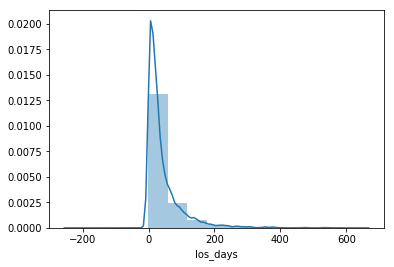

In [69]:
sns.distplot(df_los_demo['los_days'],kde=True,bins=15)

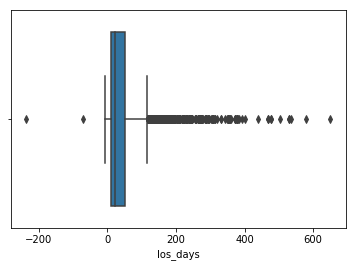

In [70]:
sns.boxplot(x=df_los_demo['los_days'])

In [71]:
#remove outliers which are 2 standard deviations away from mean
def remove_outliers(data,col):
    from scipy import stats
    z_score=np.abs(stats.zscore(data[col]))
    data=data[z_score<2]
    data=data[data[col]>0]
    return data
    

In [72]:
df_los_p=remove_outliers(df_los_demo,'los_days')

In [73]:
df_los_p.sample(5)

,EpisodeReference,HospitalNumber,From_WardId,TransferType,Start_Date,End_Date,Ward,los_days,start_month,Ward Code,Ward Name,Ward Service Type,Ward Location,Age,Gender
3426,107672,1027.0,0,0.0,2018-10-11 11:00:00,2019-02-06 14:00:00,I_RXTD4_MELISSA,118,10,I_RXTD4_MELISSA,Oleaster - Melissa,Adult Acute,Oleaster,38,F
4427,107106,699.0,Highcroft - George,15.0,2018-07-19 11:25:00,2018-08-09 18:34:00,I_RXT18_ELIG,21,7,I_RXT18_ELIG,Highcroft - George,Adult Acute,Highcroft Site,62,M
129,108484,2239.0,0,0.0,2019-02-19 15:30:00,2019-04-23 16:51:00,I_RXT47_MS1,63,2,I_RXT47_MS1,Mary Seacole House - Ward 1,Adult Acute,Mary Seacole House,48,M
709,106280,1150.0,Oleaster - Magnolia,14.0,2018-03-15 04:05:00,2018-03-17 22:13:00,I_RXTD4_MAGNO,2,3,I_RXTD4_MAGNO,Oleaster - Magnolia,Adult Acute,Oleaster,26,M
5343,107495,2563.0,0,0.0,2018-09-13 14:20:00,2018-09-20 18:30:00,I_RXT47_MS1,7,9,I_RXT47_MS1,Mary Seacole House - Ward 1,Adult Acute,Mary Seacole House,27,M


In [74]:
df_los_p.isna().sum()

EpisodeReference      0
HospitalNumber        0
From_WardId           0
TransferType          0
Start_Date            0
End_Date              0
Ward                  0
los_days              0
start_month           0
Ward Code             0
Ward Name             0
Ward Service Type     0
Ward Location         0
Age                   0
Gender               11
dtype: int64

In [75]:
df_los_p.dropna(how='any',inplace=True)

In [76]:
#Save the processed dataframe as csv
df_los_p.to_csv('df_los_p_o.csv',index=False)

In [77]:
df_los_p_1=df_los_p.copy()

In [78]:
df_los_p_1.drop(['Ward'],axis=1,inplace=True)

In [79]:
df_los_p_1.columns

Index(['EpisodeReference', 'HospitalNumber', 'From_WardId', 'TransferType',
       'Start_Date', 'End_Date', 'los_days', 'start_month', 'Ward Code',
       'Ward Name', 'Ward Service Type', 'Ward Location', 'Age', 'Gender'],
      dtype='object')